# Ghan's aerosol simulator
1. check differences between original Fortran and this Python implementation. I think due to
  - numerical precision error in some components
  - inaccuracies (0.333 versus 1/3), line 1351
  - small errors in Ghan's original code
2. refactor as much as possible
3. naerpd is not being used if there is a different present day emissions?
4. accumulation mode of naernat has a huge influence on the PD forcing.
5. `distanthro` parameter: OK correspondence with Ghan except for `ccn` where Ghan's original code gives silly number, and `number` where difference is about 0.13 W/m2.

In [1]:
from fair.forcing import ghan_indirect
import numpy as np

In [2]:
help(ghan_indirect)

Help on module fair.forcing.ghan_indirect in fair.forcing:

NAME
    fair.forcing.ghan_indirect

FILE
    /nfs/see-fs-02_users/mencsm/FAIR/fair/forcing/ghan_indirect.py

DESCRIPTION
    # Aerosol indirect effects global model
    # Original FORTRAN code by Steve Ghan and colleagues
    # Ghan et al, 2013: A simple model of global aerosol indirect effects
    # doi 10.1002/jgrd.50567

FUNCTIONS
    cloud(sigh, fcloud, w, naer, rad, hygro, sigma, rcrit, ndmin, l_wood, tau_rep, r_emb, ncld=20, sccn=0.001)
        Calculates cloud albedo which is the returned value
        sccn: supersaturation for partitioning by CCN
        
        ncld: number of cloud pdf steps
    
    ghan_indirect(npdf=10, scaleh=3000.0, rho_aer=1700.0, lifetime=4.0, sigh=200.0, w=0.3, ndmin=0, srfalbedo=0.1, aername=['Accumulation', 'Aitken', 'Coarse'], naernat=array([2.50e+08, 1.55e+08, 1.70e+06]), radnat=array([7.10e-08, 1.49e-08, 7.84e-07]), sigma=array([1.8, 1.6, 1.8]), naerpd=array([3.86e+08, 1.95e+08, 1.70e+

In [3]:
ghan_indirect.ghan_indirect(l_wood=False, cldloc='uniform', rcrit=10e-6)

-1.304892542039519

In [4]:
%%timeit
ghan_indirect.ghan_indirect(l_wood=False, cldloc='uniform', rcrit=10e-6)

100 loops, best of 3: 2.34 ms per loop


In [5]:
%%timeit
ghan_indirect.ghan_indirect(l_wood=True, cldloc='uniform', rcrit=10e-6)

/nfs/see-fs-02_users/mencsm/FAIR/fair/forcing/ghan_indirect.py:56: RuntimeWarning: overflow encountered in double_scalars
  Q[2] = 4*np.pi*RHO_WATER*rv**3/(3*Q[1])
/nfs/see-fs-02_users/mencsm/FAIR/fair/forcing/ghan_indirect.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  rv = 3 * Q[1] / (4 * np.pi * RHO_WATER * Q[2])
/nfs/see-fs-02_users/mencsm/FAIR/fair/forcing/ghan_indirect.py:51: RuntimeWarning: overflow encountered in double_scalars
  rv = 3 * Q[1] / (4 * np.pi * RHO_WATER * Q[2])


10 loops, best of 3: 57.3 ms per loop


In [6]:
# ghan_indirect.ghan_indirect(l_wood=True)
# # default options gives -1.151445816219689


# loop back in while I figure out what's going on
    
#    # for m in range npdf:
#    # rad had shape (3)
#    # naer had shape (3)
#    # anthroso4b.shape = 10, scaleh.shape = float, fracmode.shape = 3
#    # expand array to [npdf, nmodes]
#    anthroso4conc = anthroso4b[:,None] / scaleh * fracmode[None,:]
#    anthrosoaconc = anthrosoab[:,None] / scaleh * fracmode[None,:]
#    anthropconc   = anthropb[:,None]   / scaleh * fracmode[None,:]
#    anthroconc    = anthroso4conc + anthrosoaconc
#    nanthrop = 3. * anthropconc / (4 * np.pi * rho_aer * radp**3) * np.exp(-4.5 * np.log(sigma)**2)
#    rad  = (3. * (natconc + anthropconc + (1.-fnewn) * anthroconc) / (4. * (naernat + nanthrop) * np.pi * rho_aer))**(1/3.) * np.exp(-1.5 * np.log(sigma)**2)
#    naer = (natconc + anthropconc + anthroconc) * (naernat + nanthrop)/(natconc + anthropconc + (1.-fnewn) * anthroconc)
#    print rad.shape, naer.shape
#    hygro= (hygronat * natconc + anthroso4conc * hygroso4 + anthrosoaconc * hygrosoa)/(natconc + anthroconc + anthropconc)
#    pdcldalbedo = cloud(sigh, cldfrac, w, naer, rad, hygro, sigma, rcrit, ndmin, l_wood, tau_rep, R_EMB)
#    pdtranscld = 1.-pdcldalbedo
#    net_local = (1.-cldfrac) * (1-srfalbedo) + cldfrac * pdtranscld * (1.-srfalbedo)/(1.-srfalbedo*pdcldalbedo)
#    pdnet = np.sum(fanthro * net_local)

In [7]:
# # run ECHAM5-HAM
# import numpy as np
# ghan_indirect.ghan_indirect(l_wood=False, rcrit=100e-6,
#                            naernat = np.array([87, 292, 1.68]) * 1e6,
#                            radnat         = np.array([0.083, 0.013, 0.52]) * 1e-6,   # m
#                             sigma          = np.array([1.59, 1.59, 2.0]),            # geom. stdev of bins
#                            #naerpd  = np.array([180, 313, 1.9]) * 1e6,
#                             so4nat = np.array([0.33, 0.011, 0.03]) * 1e-9/1.2,
#                             soanat = np.array([0.08, 0.001, 0]) * 1e-9/1.2,
#                             bcnat  = np.array([0.01, 0., 0.]) * 1e-9/1.2,
#                             pomnat = np.array([0.13, 0.003, 0.]) * 1e-9/1.2,
#                            seasaltnat=np.array([0.66, 0., 16.2]) * 1e-9/1.2,
#                             dustnat = np.array([0.06, 0., 2.11]) * 1e-9/1.2,
#                             emitso4 = 104,
#                             emitsoa = 12,
#                             emitp = 59,
#                            srfalbedo=0.10)

In [8]:
## skeie natural emissions
#natural_skeie = np.array([13, 180, 39])

[-3.77753384e-14 -2.10374845e-02]


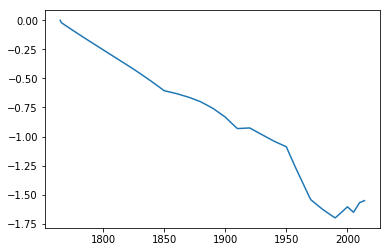

In [9]:
from fair.RCPs import rcp85
from fair.constants import molwt
import numpy as np

#print rcp85.Emissions.sox * molwt.SO2/molwt.S
#print rcp85.Emissions.bc + rcp85.Emissions.oc

# results = np.zeros(250)
results2 = np.zeros(250)

for i in range(250):
    results2[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
                                  emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
                                  emitsoa = rcp85.Emissions.nmvoc[i]/15.,
                                  l_wood=False)
#     results[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
#                                   emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
#                                   #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
#                                   l_wood=True)

import matplotlib.pyplot as pl
%matplotlib inline

# pl.plot(results)
pl.plot(np.arange(1765,2015), results2)
print results2[0:2]

In [10]:
# pl.plot(results2/results)
# #pl.plot(rcp85.Emissions.sox * molwt.SO2/molwt.S)
# #pl.plot(rcp85.Emissions.bc + rcp85.Emissions.oc)
# #pl.plot(rcp85.Emissions.nmvoc)

In [11]:
# from fair.RCPs import rcp85
# from fair.constants import molwt
# import numpy as np

In [12]:
%%timeit
for i in range(250):
    ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
                                  emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
                                  #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
                                  l_wood=False)

1 loop, best of 3: 604 ms per loop


In [13]:
# from fair.forward import fair_scm

In [14]:
# %%timeit
# fair_scm(emissions=rcp85.Emissions.emissions)

In [15]:
# ghan_indirect.ghan_indirect(l_wood=False,
#                             npdf=4,
#                             w=0.1)

In [16]:
# for i in range(250):
#     results2[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
#                                   emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
#                                   #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
#                                   l_wood=False,
#                                   w=0.1)
#     results[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
#                                   emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
#                                   #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
#                                   l_wood=False,
#                                   w=1.2)

In [17]:
# pl.plot(results)
# pl.plot(results2)

In [18]:
# np.minimum(np.array([0.33, 0.011, 0.03]), 0)

In [19]:
# import numpy as np
# import scipy.stats as st

In [20]:
# st.expon.ppf(np.arange(0.05,1,0.1))

In [21]:
# %%timeit
# ghan_indirect.ghan_indirect(l_wood=True)

In [22]:
# %%timeit
# for i in range(250):
#     results2[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
#                                   emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
#                                   #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
#                                   l_wood=True,
#                                   )

In [23]:
# %%timeit
# for i in range(250):
#     results2[i] = ghan_indirect.ghan_indirect(emitso4=rcp85.Emissions.sox[i] * molwt.SO2/molwt.S,
#                                   emitp = rcp85.Emissions.bc[i] + rcp85.Emissions.oc[i],
#                                   #emitsoa = rcp85.Emissions.nmvoc[i]*0.1,
#                                   l_wood=False,
#                                   )